# Inverse Ising problem

This notebook gives examples of how to use the various solvers included in CONIII for solving the inverse Ising problem. In this problem, the goal is to match the average of each spin (the magnetization) $\{\langle\sigma_{\rm i}\rangle\}$ and the pairwise correlations $\{\langle\sigma_{\rm i}\sigma_{\rm j}\rangle\}$ by finding the fields $\{h_{\rm i}\}$ and couplings $\{J_{\rm ij}\}$.

The Ising model is given by  
$p(\{\sigma_{\rm i}\}) = \left.e^{-E(\{\sigma_{\rm i}\})}\right/Z$  
$\displaystyle E(\{\sigma_{\rm i}\}) = -\sum_{\rm ij}J_{\rm ij}\sigma_{\rm i}\sigma_{\rm j} -\sum_{\rm i}^Nh_{\rm i}$  
$Z = \displaystyle \sum_{\{\sigma_{\rm i}\}} e^{-E(\{\sigma_{\rm i}\})}$

In [19]:
# Setup iPython environment.
%pylab inline
plt.rc('font',size=20)

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# Import common libraries.
from __future__ import division
from solvers import *
from utils import *
import ising_eqn_5_sym

# Define common functions.
calc_e,calc_observables,mchApproximation = define_ising_helpers_functions()

# Generate example data set.
n = 5  # system size
np.random.seed(0)
h,J = np.random.normal(scale=.1,size=n),np.random.normal(scale=.1,size=n*(n-1)//2)  # random fields, couplings
hJ = np.concatenate((h,J))
p = ising_eqn_5_sym.p(hJ)  # probability distribution of all states p(s)
sisjTrue = ising_eqn_5_sym.calc_observables(hJ)  # exact magnetizations and pairwise correlations

allstates = bin_states(n,True)  # all 2^n possible binary states in {-1,1} basis
sample = allstates[random.choice(range(2**n),size=100,replace=True,p=p)]  # random sample from p(s)
sisj = pair_corr(sample,concat=True)  # magnetizations and pairwise correlations of random sample

# Enumeration example.

Enumerate all constraint equations and solve them using scipy.optimize.minimize. All the equations have been written to the file "ising_eqn_5_sym.py" by calling
>python exact.py 5 1

In this case, the exact (not sampled) $\langle\sigma_{\rm i}\rangle$ and $\langle\sigma_{\rm i}\sigma_{\rm j}\rangle$ are given and the exact solution is found.

In [3]:
# Define function specifically needed for creating Exact class.
def calc_observables_multipliers(J):
    """
    Calculate observables from probability distribution given Langrangian multipliers.
    """
    E = calc_e(allstates,J)
    return pair_corr( allstates, np.exp(-E-logsumexp(E)),concat=True )

# Declare and call solver.
solver = Exact(n,
               calc_observables_multipliers=calc_observables_multipliers,
               calc_observables=calc_observables)
estMultipliers,soln = solver.solve(constraints=sisjTrue,fsolve_kwargs={})

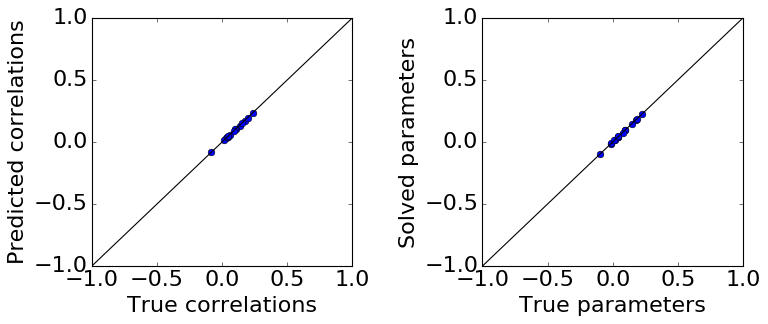

In [4]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4),ncols=2)
ax[0].plot(sisjTrue,ising_eqn_5_sym.calc_observables(estMultipliers),'o')
ax[0].plot([-1,1],[-1,1],'k-')
ax[0].set(xlabel='True correlations',ylabel='Predicted correlations')

ax[1].plot(hJ,soln['x'],'o')
ax[1].plot([-1,1],[-1,1],'k-')
ax[1].set(xlabel='True parameters',ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

## Minimum probability flow (MPF)

In [5]:
# Declare and call solver.
solver = MPF(n,calc_observables=calc_observables,adj=adj)
estMultipliers,soln = solver.solve(sample)

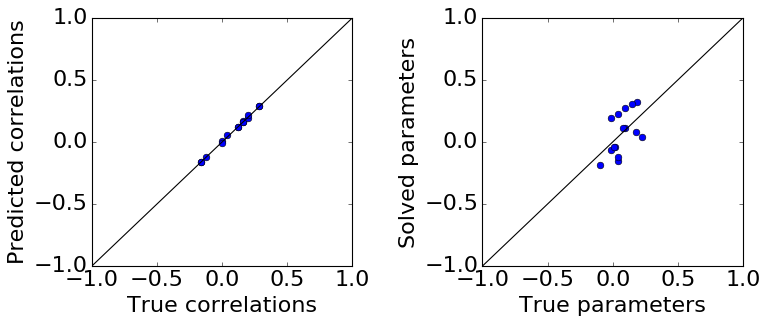

In [6]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4),ncols=2)
ax[0].plot(sisj,ising_eqn_5_sym.calc_observables(estMultipliers),'o')
ax[0].plot([-1,1],[-1,1],'k-')
ax[0].set(xlabel='True correlations',ylabel='Predicted correlations')

ax[1].plot(hJ,estMultipliers,'o')
ax[1].plot([-1,1],[-1,1],'k-')
ax[1].set(xlabel='True parameters',ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Pseudolikelihood

In [8]:
get_multipliers_r,calc_observables_r = define_pseudo_ising_helpers(n)

solver = Pseudo(n,calc_observables=calc_observables,
                calc_observables_r=calc_observables_r,
                get_multipliers_r=get_multipliers_r)
estMultipliers,_ = solver.solve(sample,zeros(15))

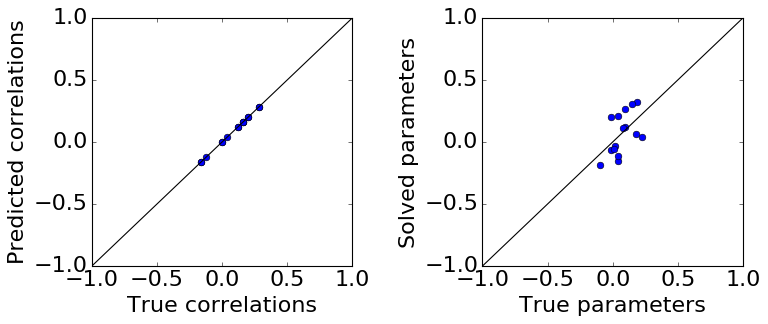

In [9]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4),ncols=2)
ax[0].plot(sisj,ising_eqn_5_sym.calc_observables(estMultipliers),'o')
ax[0].plot([-1,1],[-1,1],'k-')
ax[0].set(xlabel='True correlations',ylabel='Predicted correlations')

ax[1].plot(hJ,estMultipliers,'o')
ax[1].plot([-1,1],[-1,1],'k-')
ax[1].set(xlabel='True parameters',ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Adaptive cluster expansion

In [21]:
solver = ClusterExpansion(n,calc_observables=calc_observables)

threshold = 0.001
estMultipliers = solver.solve(sample,threshold)

adaptiveClusterExpansion: Clusters of size 2
adaptiveClusterExpansion: Clusters of size 3
adaptiveClusterExpansion: Clusters of size 4


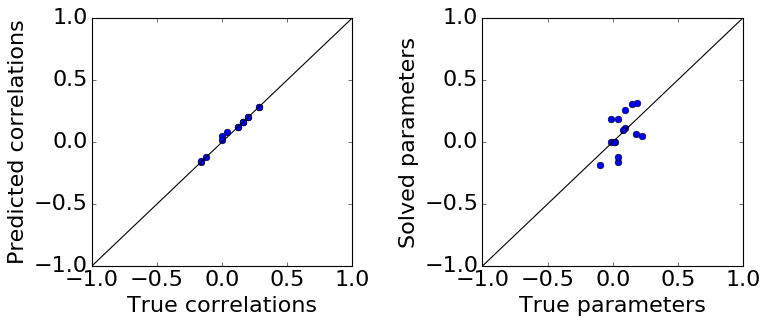

In [22]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4),ncols=2)
ax[0].plot(sisj,ising_eqn_5_sym.calc_observables(estMultipliers),'o')
ax[0].plot([-1,1],[-1,1],'k-')
ax[0].set(xlabel='True correlations',ylabel='Predicted correlations')

ax[1].plot(hJ,estMultipliers,'o')
ax[1].plot([-1,1],[-1,1],'k-')
ax[1].set(xlabel='True parameters',ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Monte Carlo histogram (MCH)

MCH loops a sampling step for approximating the distribution with the current set of multipliers and then a run of the MCH approximation step on that sample. This method is the slowest because of the time required for sampling from  $p(\sigma)$. The size of the sample will determine how accurately the algorithm could converge to the answer.

In [13]:
# Declare and call solver.
solver = MCH(n,calc_observables=calc_observables,
             sample_size=100,
             sample_method='metropolis',
             mch_approximation=mchApproximation)

# Manually iterate over different parameters.
# maxiter fixes the number of times the sampler is allowed to run.
soln = solver.solve(sisj,maxiter=10)
soln = solver.solve(sisj,initial_guess=soln,maxiter=10,
                    learn_params_kwargs={'maxdlamda':.1,'eta':.1})
estMultipliers = solver.solve(sisj,initial_guess=soln,maxiter=20,
                              learn_params_kwargs={'maxdlamda':.05,'eta':.05})

Over maxiter
Over maxiter
Over maxiter


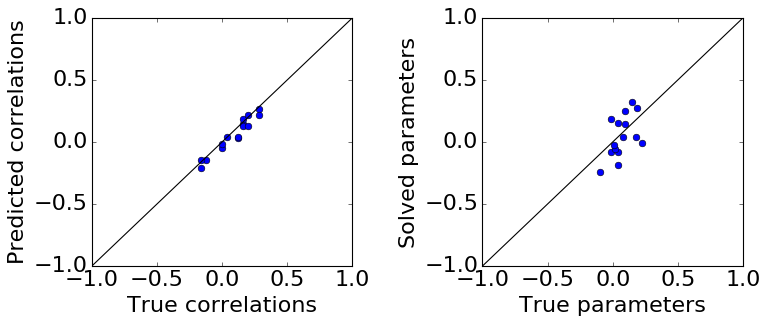

In [23]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4),ncols=2)
ax[0].plot(sisj,ising_eqn_5_sym.calc_observables(estMultipliers),'o')
ax[0].plot([-1,1],[-1,1],'k-')
ax[0].set(xlabel='True correlations',ylabel='Predicted correlations')

ax[1].plot(hJ,estMultipliers,'o')
ax[1].plot([-1,1],[-1,1],'k-')
ax[1].set(xlabel='True parameters',ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Regularized mean field

In [29]:
# TO DO : Is the random sampling seed actually remaining fixed?
# TO DO : Is symmetrizing J (in at least two places) being done correctly?

solver = RegularizedMeanField(n,calc_observables=calc_observables)

estMultipliers = solver.solve(sample,numSamples=100)

coocSampleCovariance : WARNING : using ad-hoc 'Laplace' correction
RegularizedMeanField.solve: Tried 0.0
RegularizedMeanField.solve: sum(dc**2) = 2937.180902
RegularizedMeanField.solve: Tried 1.0
RegularizedMeanField.solve: sum(dc**2) = 2846.8192959
RegularizedMeanField.solve: Tried 2.618034
RegularizedMeanField.solve: sum(dc**2) = 2069.3352214
RegularizedMeanField.solve: Tried 5.23606802516
RegularizedMeanField.solve: sum(dc**2) = 1268.19711344
RegularizedMeanField.solve: Tried 7.6412015784
RegularizedMeanField.solve: sum(dc**2) = 1554.69229941
RegularizedMeanField.solve: Tried 5.23606802516
RegularizedMeanField.solve: sum(dc**2) = 1472.32880914
RegularizedMeanField.solve: Tried 4.2360680407
RegularizedMeanField.solve: sum(dc**2) = 1396.80770793
RegularizedMeanField.solve: Tried 3.61803405031
RegularizedMeanField.solve: sum(dc**2) = 2158.94579038
RegularizedMeanField.solve: Tried 4.68938163519
RegularizedMeanField.solve: sum(dc**2) = 1804.35498648
RegularizedMeanField.solve: Tried 4.0

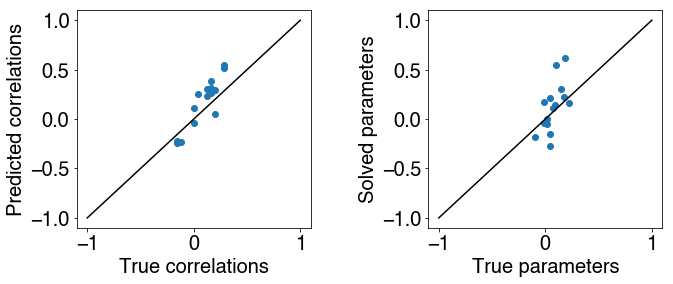

In [30]:
# Plot comparison of model results with the data.
fig,ax = plt.subplots(figsize=(10.5,4),ncols=2)
ax[0].plot(sisj,ising_eqn_5_sym.calc_observables(estMultipliers),'o')
ax[0].plot([-1,1],[-1,1],'k-')
ax[0].set(xlabel='True correlations',ylabel='Predicted correlations')

ax[1].plot(hJ,estMultipliers,'o')
ax[1].plot([-1,1],[-1,1],'k-')
ax[1].set(xlabel='True parameters',ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)